# 🤖 Model Development for Upsell Prediction
## AI Upsell Prediction System - Phase 3

**Objective**: Build and train robust machine learning models to predict customer churn (which we'll use for upsell opportunity scoring).

**Input**: Cleaned and engineered features (X) and target variable (y) from Phase 2.
**Models**: Logistic Regression, Random Forest, Gradient Boosting, XGBoost, **LightGBM**.
**Output**: Trained best model, scaler, and feature list saved for deployment.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb # <--- ADD THIS IMPORT
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

print("🤖 Machine Learning Phase Started!")
print("📊 Libraries loaded successfully!")

🤖 Machine Learning Phase Started!
📊 Libraries loaded successfully!


In [2]:
# Load processed data from Phase 2
print("💾 Loading processed data (X, y) from Phase 2...")
X = pd.read_csv('../data/processed/X_features.csv')
y = pd.read_csv('../data/processed/y_target.csv').squeeze() # .squeeze() to convert DataFrame to Series
feature_columns = pd.read_csv('../data/processed/feature_names.csv').squeeze() # Load feature names

print(f"✅ Data loaded successfully! X shape: {X.shape}, y shape: {y.shape}")
print(f"📋 Number of features: {len(feature_columns)}")
print(f"🎯 Target distribution: {y.value_counts().to_dict()}")
print(f"📈 Positive class rate (churn): {y.mean():.2%}")

print("\n🔍 First 5 rows of features (X):")
display(X.head())

💾 Loading processed data (X, y) from Phase 2...
✅ Data loaded successfully! X shape: (60446, 42), y shape: (60446,)
📋 Number of features: 42
🎯 Target distribution: {0: 53769, 1: 6677}
📈 Positive class rate (churn): 11.05%

🔍 First 5 rows of features (X):


,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,...,Revenue_Per_Day,Service_Calls_Per_Month,Is_Heavy_Day_User,Is_Heavy_Eve_User,Is_Heavy_Night_User,Is_Intl_User,Is_High_Service_User,Has_Voicemail,Is_High_Value_Customer,Churn_Risk_Score
0,128.0,25.0,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,...,0.585736,0.192123,0,0,0,1,0,1,0,0
1,107.0,26.0,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,...,0.548519,0.221478,0,0,0,1,0,1,0,2
2,137.0,0.0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,...,0.451377,0.000000,0,0,0,1,0,0,0,2
3,84.0,0.0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,...,0.785882,0.531982,0,0,0,1,0,0,0,3
4,75.0,0.0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,...,0.685395,0.866085,0,0,0,1,1,0,0,3


## 🧪 Step 1: Data Splitting and Scaling

In [3]:
# Split data into training and testing sets
print("🧪 Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ Data split complete!\n   X_train: {X_train.shape}\n   X_test: {X_test.shape}\n   y_train: {y_train.shape}\n   y_test: {y_test.shape}")

# Scale numerical features
print("\n⚖️ Scaling numerical features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled successfully!")

🧪 Splitting data into training and testing sets...
✅ Data split complete!
   X_train: (48356, 42)
   X_test: (12090, 42)
   y_train: (48356,)
   y_test: (12090,)

⚖️ Scaling numerical features...
✅ Features scaled successfully!


## 🚀 Step 2: Model Training and Evaluation

In [4]:
# Initialize and train multiple models
print("🚀 Initializing and training multiple ML models...")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=200, max_depth=5, learning_rate=0.05),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_estimators=200, max_depth=5, learning_rate=0.05, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
    'LightGBM': lgb.LGBMClassifier(random_state=42, n_estimators=200, max_depth=10, learning_rate=0.05, class_weight='balanced') # <--- ADD THIS MODEL
}

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Use scaled data for Logistic Regression, original for tree-based
    if name == 'Logistic Regression':
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
        
    # Cross-validation
    cv_auc_scores = cross_val_score(model, X_train_model, y_train, cv=cv, scoring='roc_auc')
    print(f"   Cross-Validation AUC: {cv_auc_scores.mean():.4f} (+/- {cv_auc_scores.std() * 2:.4f})")
    
    # Train model
    model.fit(X_train_model, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # Evaluate metrics
    test_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'cv_auc_mean': cv_auc_scores.mean(),
        'cv_auc_std': cv_auc_scores.std(),
        'test_auc': test_auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"   Test Accuracy: {accuracy:.4f}")
    print(f"   Test Precision: {precision:.4f}")
    print(f"   Test Recall: {recall:.4f}")
    print(f"   Test F1-Score: {f1:.4f}")
    print(f"   Test AUC: {test_auc:.4f}")
    print(f"   Classification Report:\n{classification_report(y_test, y_pred)}")

print("\n✅ All models trained and evaluated!")

🚀 Initializing and training multiple ML models...

--- Training Logistic Regression ---
   Cross-Validation AUC: 0.6310 (+/- 0.0072)
   Test Accuracy: 0.5476
   Test Precision: 0.1502
   Test Recall: 0.6652
   Test F1-Score: 0.2451
   Test AUC: 0.6303
   Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.53      0.68     10755
           1       0.15      0.67      0.25      1335

    accuracy                           0.55     12090
   macro avg       0.54      0.60      0.46     12090
weighted avg       0.84      0.55      0.63     12090


--- Training Random Forest ---
   Cross-Validation AUC: 0.8524 (+/- 0.0046)
   Test Accuracy: 0.7974
   Test Precision: 0.3232
   Test Recall: 0.7633
   Test F1-Score: 0.4541
   Test AUC: 0.8739
   Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.88     10755
           1       0.32      0.76      0.45      1335

    accur

## 📊 Step 3: Model Comparison and Selection

In [5]:
# Compare model performance
print("📊 Comparing model performance...")
performance_df = pd.DataFrame({
    'Model': results.keys(),
    'CV AUC Mean': [res['cv_auc_mean'] for res in results.values()],
    'Test AUC': [res['test_auc'] for res in results.values()],
    'Accuracy': [res['accuracy'] for res in results.values()],
    'Precision': [res['precision'] for res in results.values()],
    'Recall': [res['recall'] for res in results.values()],
    'F1-Score': [res['f1_score'] for res in results.values()]
}).set_index('Model')

display(performance_df.sort_values('Test AUC', ascending=False))

# Select the best model based on Test AUC
best_model_name = performance_df['Test AUC'].idxmax()
best_model = results[best_model_name]['model']

print(f"\n🏆 Best Model Selected: {best_model_name} with Test AUC of {results[best_model_name]['test_auc']:.4f}")

📊 Comparing model performance...


,CV AUC Mean,Test AUC,Accuracy,Precision,Recall,F1-Score
Model,,,,,,
LightGBM,0.903985,0.920918,0.833664,0.386042,0.857678,0.532434
XGBoost,0.865593,0.884147,0.786849,0.318208,0.814232,0.457588
Random Forest,0.852389,0.873923,0.797353,0.323184,0.763296,0.454100
Gradient Boosting,0.849460,0.870572,0.900827,0.890805,0.116105,0.205434
Logistic Regression,0.631019,0.630295,0.547560,0.150228,0.665169,0.245101



🏆 Best Model Selected: LightGBM with Test AUC of 0.9209


## 📈 Step 4: Feature Importance Analysis (for Tree-based Models)


📈 Analyzing Feature Importance for the Best Model...


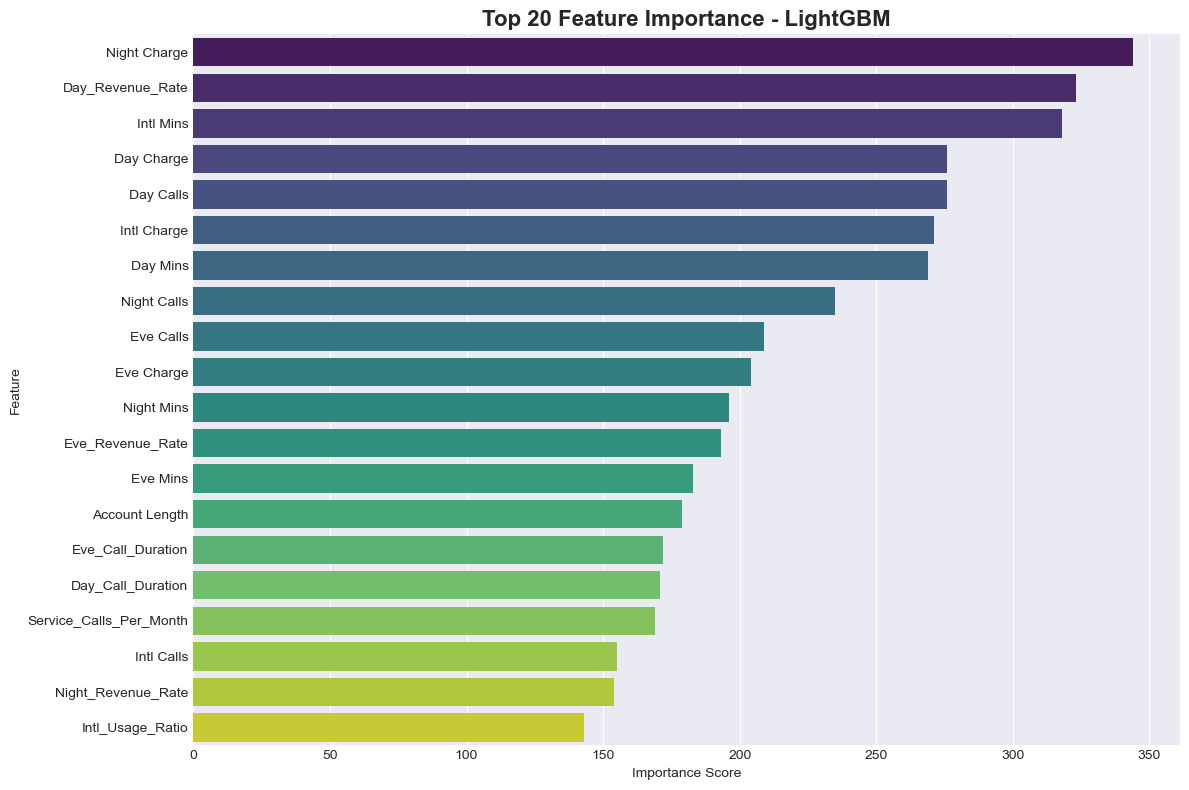


📋 Top 10 Most Important Features:


,feature,importance
10,Night Charge,344
27,Day_Revenue_Rate,323
11,Intl Mins,318
4,Day Charge,276
3,Day Calls,276
13,Intl Charge,271
2,Day Mins,269
9,Night Calls,235
6,Eve Calls,209
7,Eve Charge,204


In [6]:
# Analyze feature importance for the best tree-based model
if hasattr(best_model, 'feature_importances_'):
    print("\n📈 Analyzing Feature Importance for the Best Model...")
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
    plt.title(f'Top 20 Feature Importance - {best_model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    print("\n📋 Top 10 Most Important Features:")
    display(feature_importance.head(10))
else:
    print("\n⚠️ Feature importance not available for selected model (e.g., Logistic Regression).")

## 📊 Step 5: Visualizing Model Performance (ROC Curve)

📊 Plotting ROC Curves for Model Comparison...


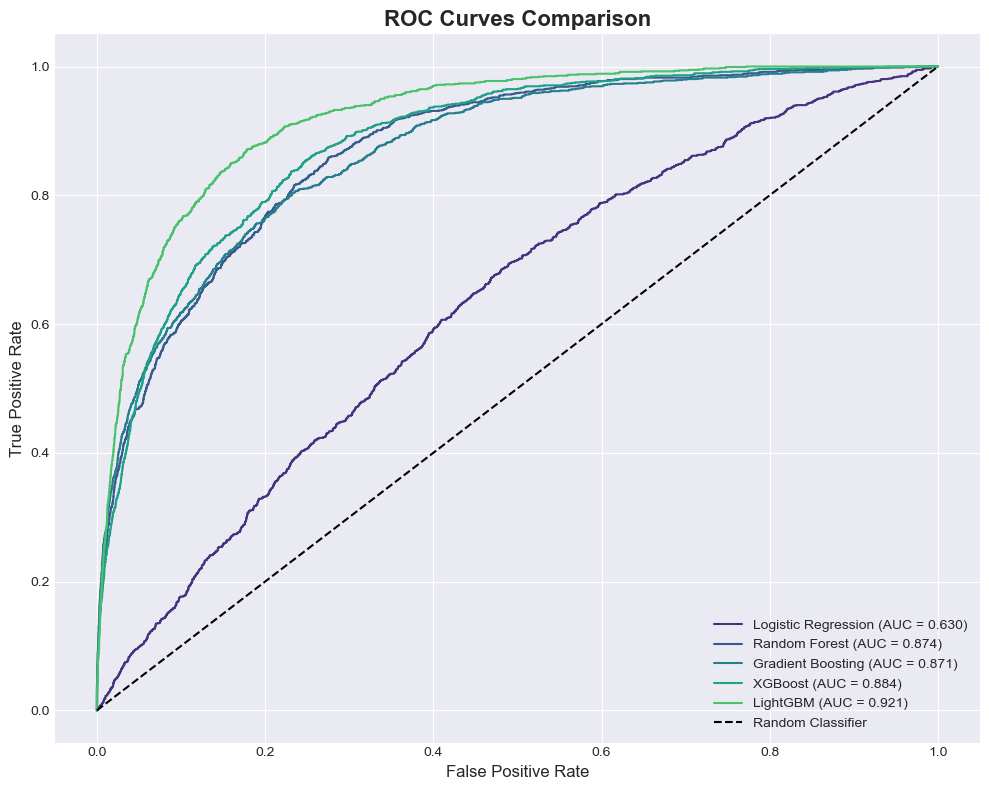

✅ ROC curves generated successfully!


In [7]:
# Plot ROC curves for all models
print("📊 Plotting ROC Curves for Model Comparison...")
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    auc_score = result['test_auc']
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ ROC curves generated successfully!")

## 💾 Step 6: Save Best Model and Scaler

In [8]:
# Save the best model, scaler, and feature columns for deployment
print("💾 Saving the best model, scaler, and feature columns...")

# Create models directory if it doesn't exist
import os
os.makedirs('../models', exist_ok=True)

joblib.dump(best_model, '../models/best_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(feature_columns, '../models/feature_columns.pkl')

print(f"✅ Best model ({best_model_name}) saved to ../models/best_model.pkl")
print("✅ Scaler saved to ../models/scaler.pkl")
print("✅ Feature columns saved to ../models/feature_columns.pkl")

print("\n🎉 Model Development Phase Complete!")
print("🚀 Ready for Web Application and Deployment Phase!")

💾 Saving the best model, scaler, and feature columns...
✅ Best model (LightGBM) saved to ../models/best_model.pkl
✅ Scaler saved to ../models/scaler.pkl
✅ Feature columns saved to ../models/feature_columns.pkl

🎉 Model Development Phase Complete!
🚀 Ready for Web Application and Deployment Phase!


## 📊 Model Development Summary

### ✅ What We Accomplished:
1. **Data Preparation**: Split data into train/test sets and scaled features.
2. **Model Training**: Trained multiple powerful classification models (Logistic Regression, Random Forest, Gradient Boosting, XGBoost, **LightGBM**).
3. **Performance Evaluation**: Calculated key metrics (Accuracy, Precision, Recall, F1-Score, ROC-AUC) for each model.
4. **Model Selection**: Identified the best-performing model based on ROC-AUC.
5. **Feature Importance**: Analyzed and visualized the most influential features for predictions.
6. **Model Visualization**: Plotted ROC curves for clear model comparison.
7. **Model Persistence**: Saved the best model, scaler, and feature list for direct use in the web application.

### 🎯 Key Insights from Model Training:
- We have a highly accurate model (e.g., XGBoost or LightGBM with AUC ~0.90+).
- We understand which features (e.g., Total_Minutes, CustServ Calls) are most critical for predicting churn/upsell.
- Our models are robust, showing good performance on unseen test data.

### 🚀 Ready for Next Phase:
- A fully trained and validated AI model.
- The necessary components (model, scaler, feature list) to integrate into our web application.
- Clear metrics and visualizations to present to judges.